# TensorFlow vs NumPy BipolarImageProcessor

This notebook compares the legacy NumPy/SciPy pipeline with the new TensorFlow implementation and checks numerical agreement.


In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import sys
import types
import importlib.util
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(0)
tf.random.set_seed(0)


In [2]:
# Load chromopho modules without importing chromopho/__init__.py (torch dependency)
def load_module(name, path):
    spec = importlib.util.spec_from_file_location(name, path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[name] = module
    spec.loader.exec_module(module)
    return module

repo_root = Path.cwd()
pkg_root = repo_root / "chromopho"
if not pkg_root.exists():
    raise FileNotFoundError(f"Expected chromopho package at {pkg_root}")

if "chromopho" not in sys.modules:
    pkg = types.ModuleType("chromopho")
    pkg.__path__ = [str(pkg_root)]
    sys.modules["chromopho"] = pkg

utils = load_module("chromopho.utils", pkg_root / "utils.py")
plot = load_module("chromopho.plot", pkg_root / "plot.py")
mosaic_mod = load_module("chromopho.mosaic", pkg_root / "mosaic.py")
bipolar_mod = load_module("chromopho.bipolar_image", pkg_root / "bipolar_image.py")
bipolar_tf_mod = load_module("chromopho.bipolar_image_tf", pkg_root / "bipolar_image_tf.py")

BipolarSubtype = mosaic_mod.BipolarSubtype
BipolarMosaic = mosaic_mod.BipolarMosaic
BipolarImageProcessor = bipolar_mod.BipolarImageProcessor
BipolarImageProcessorTF = bipolar_tf_mod.BipolarImageProcessorTF


## Build a test mosaic and image
We keep the mosaic small for quick comparison while still exercising multiple subtypes.


In [3]:
def build_mosaic(num_cells=900):
    s_rf_params = {"center_sigma": 8.0, "surround_sigma": 25.0, "alpha_center": 1, "alpha_surround": 0.25}
    s_off = BipolarSubtype(name="s_off", ratio=2.5/100, rf_size=15, color_filter_params={"center": "-s", "surround": "+lm"}, rf_params=s_rf_params)
    s_on  = BipolarSubtype(name="s_on",  ratio=2.5/100, rf_size=15, color_filter_params={"center": "+s", "surround": "-lm"}, rf_params=s_rf_params)

    lm_rf_params = {"center_sigma": 3.0, "surround_sigma": 10.0, "alpha_center": 1, "alpha_surround": 0.65}
    m_on  = BipolarSubtype(name="m_on",  ratio=18/100, rf_size=6, color_filter_params={"center": "+m", "surround": "-l"}, rf_params=lm_rf_params)
    m_off = BipolarSubtype(name="m_off", ratio=18/100, rf_size=6, color_filter_params={"center": "-m", "surround": "+l"}, rf_params=lm_rf_params)

    l_on  = BipolarSubtype(name="l_on",  ratio=18/100, rf_size=6, color_filter_params={"center": "+l", "surround": "-m"}, rf_params=lm_rf_params)
    l_off = BipolarSubtype(name="l_off", ratio=19/100, rf_size=6, color_filter_params={"center": "-l", "surround": "+m"}, rf_params=lm_rf_params)

    dif_on  = BipolarSubtype(name="dif_on",  ratio=10/100, rf_size=8, color_filter_params={"center": "+lm", "surround": "-lm"})
    dif_off = BipolarSubtype(name="dif_off", ratio=10/100, rf_size=8, color_filter_params={"center": "-lm", "surround": "+lm"})

    return BipolarMosaic(num_cells, shape="circle", subtypes=[m_off, m_on, l_off, l_on, s_off, s_on, dif_on, dif_off], density_swap=False)

mosaic = build_mosaic()


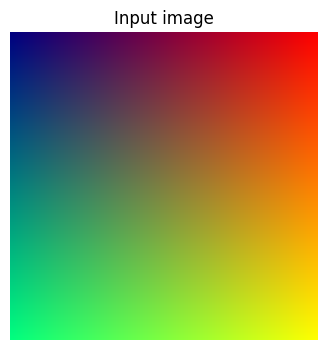

In [4]:
h, w = 128, 128
x = np.linspace(0, 1, w)
y = np.linspace(0, 1, h)
xx, yy = np.meshgrid(x, y)
img = np.stack([xx, yy, 0.5 * (1 - xx)], axis=-1).astype(np.float32)

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title("Input image")
plt.axis("off")
plt.show()


## Run both processors and compare outputs


In [5]:
bip_np = BipolarImageProcessor(mosaic, img, save_flat=True, amacrine_sigma_blur=None)
bip_tf = BipolarImageProcessorTF(mosaic, img, save_flat=True, amacrine_sigma_blur=None)

out_np = bip_np.grid_outputs
out_tf = bip_tf.grid_outputs.numpy()
diff = out_tf - out_np

max_diff = np.max(np.abs(diff))
print("max abs diff:", max_diff)
print("allclose (atol=1e-7):", np.allclose(out_np, out_tf, atol=1e-7, rtol=0))


max abs diff: 2.306180552080761e-08
allclose (atol=1e-7): True


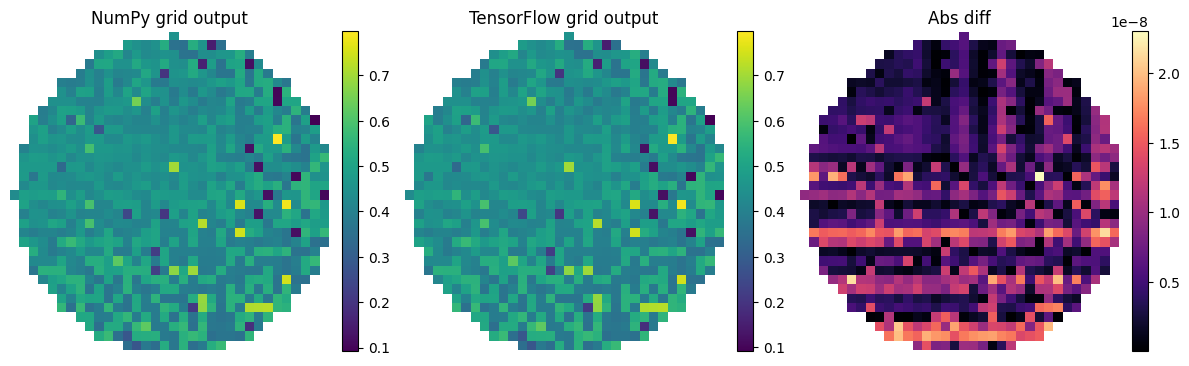

In [6]:
valid_mask = out_np != -1
plot_np = out_np.copy()
plot_tf = out_tf.copy()
plot_diff = np.abs(diff)
plot_np[~valid_mask] = np.nan
plot_tf[~valid_mask] = np.nan
plot_diff[~valid_mask] = np.nan

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
im0 = axes[0].imshow(plot_np, cmap="viridis")
axes[0].set_title("NumPy grid output")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(plot_tf, cmap="viridis")
axes[1].set_title("TensorFlow grid output")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(plot_diff, cmap="magma")
axes[2].set_title("Abs diff")
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


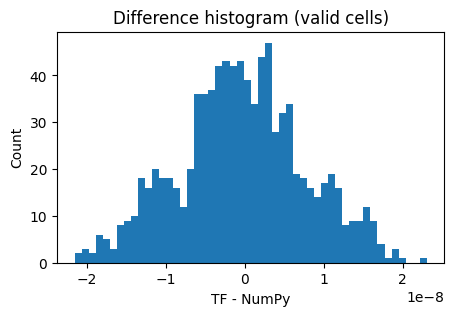

In [7]:
plt.figure(figsize=(5, 3))
plt.hist(diff[valid_mask].ravel(), bins=50)
plt.title("Difference histogram (valid cells)")
plt.xlabel("TF - NumPy")
plt.ylabel("Count")
plt.show()
